In [1]:
import matplotlib.pyplot as plt
import tss
import numpy as np
import ark
import warnings
warnings.filterwarnings("ignore")


This notebook is meant as a companion document to the Supplementary Materials, Section 8. There are no explanations except for brief code comments, and the purpose is to allow the user to follow along in the Supplementary Materials and explore the TSS algorithm on their own. The plots in the Supplementary Materials, Section 8, are recreated here, though the random seed itself may be different and the results are not identical. 

We will  study the following Gaussian model. 
$$ \rho_\lambda(x) = \frac{1}{\sqrt{2\pi}} e^{-(x-\lambda)^2 / 2}. $$
We take $\Lambda = [0, K-1]$ for some integer $K \geq 1$, and we use the discretization $\lambda_k = k / (K-1).$ 

In [2]:
# convenience functions; skip ahead for plots

from matplotlib.ticker import MaxNLocator
get_traj_key = lambda traj, key : np.array([t[key] for t in traj]).squeeze()

def make_graph(number_of_rungs, window_size, single_window):
    max_dist = number_of_rungs - 1
    gb = tss.GraphBuilder()
    edge_id = gb.add_edge(node_array = ['left', 'right'], number_of_rungs = [number_of_rungs], window_size = [window_size], primary_window_tiling_only=single_window)
    gb.add_schedule(edge_id, group_name = "mean_0", interpolation = "linear", bounds=[0, max_dist])
    graph = gb.build()
    return graph

def run_setup(name, graph, parameters, nsteps=int(1e6), write_interval=int(1e3)):
    sim = tss.Gaussian(graph, **parameters, directory=name)
    with sim.launch():
        sim.step(nsteps, write=True, write_interval=write_interval,)
    traj = sim.trajectory()
    return traj

def plot_basic(traj, suptitle=None):
    plt.subplots(figsize=(12,12))
    if(suptitle):
        plt.suptitle(suptitle)
    rungs = get_traj_key(traj, 'TSS_rung_before')
    fes =  get_traj_key(traj, 'TSS_FE')
    errs = get_traj_key(traj, 'TSS_PairErrors')
    df = fes[:, -1] - fes[:, 0]
    
    plt.subplot(2,2,2)
    plt.subplot(2,2,2)
    plt.subplot(2,2,2)
    plt.subplot(2,2,2)
    
def plot_empirical_rung_distribution(traj):
    rungs = get_traj_key(traj, 'TSS_rung_before')
    plt.title('Empirical rung distribution')
    plt.xlabel('Rung index')
    plt.ylabel('Frequency')
    plt.hist(rungs, density=True)

def plot_rung_traj(time, traj):
    rungs = get_traj_key(traj, 'TSS_rung_before')
    plt.title('Rung trajectory')
    plt.xlabel('# steps (subsampled)')
    plt.ylabel('Rung index')
    plt.plot(time, rungs, '.')
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    
def plot_final_free_energies(traj):
    fes =  get_traj_key(traj, 'TSS_FE')
    plt.title('Free energy landscape')
    plt.xlabel('Rung index')
    plt.ylabel('Free energy')    
    plt.plot(fes[-1] - fes[-1,0])
    
def plot_free_energy_traj(time, traj, errbars=False, idx0=0, color='C0', label=None):
    fes =  get_traj_key(traj, 'TSS_FE')
    df = fes[:, -1] - fes[:, 0]
    plt.title('End-to-end free energy trajectory')
    plt.xlabel('# steps (subsampled)')
    plt.ylabel('Free energy difference')
    
    plt.plot(time[idx0:], df[idx0:], color)
    if(errbars):
        errs = get_traj_key(traj, 'TSS_PairErrors')[idx0:]
        plt.fill_between(time[idx0:], -2*errs, 2*errs, color=color, alpha=0.4, label=label)


# 8.1 SAMS

In [3]:
# setup the parameters used for the simulation
# only the graphs differ
graph1 = make_graph(8, 8, True)
graph2 = make_graph(16, 16, True)
parameters = {'alpha' : 0.0, 'visit_control_eta' : 0.0, 'moves_per_estimator_update' : 1}
# The default number of steps to run with is 1e6,
# while the default write interval is 1e3;
# this defines the length of our "time" axis
# as well as its spacing.
time = np.linspace(0, int(1e6)-1, int(1e3))

In [4]:
# run the simulations 
# (warning: this may take as much as five minutes)
traj1 = run_setup('rungs8_windows1', graph1, parameters)
traj2 = run_setup('rungs16_windows1', graph2, parameters)

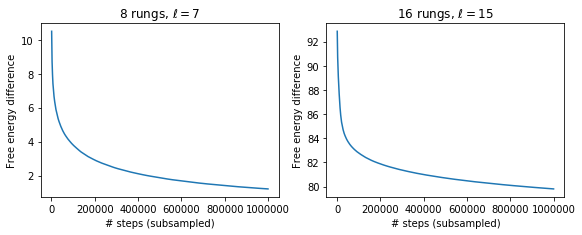

In [5]:
# plot the free energy trajectories
fig, ax = plt.subplots(figsize=(8, 3))
fig.tight_layout()
plt.subplot(1,2,1)
plot_free_energy_traj(time, traj1)
plt.title('8 rungs, $\ell = 7$')
plt.subplot(1,2,2)
plot_free_energy_traj(time, traj2)
plt.title('16 rungs, $\ell = 15$');

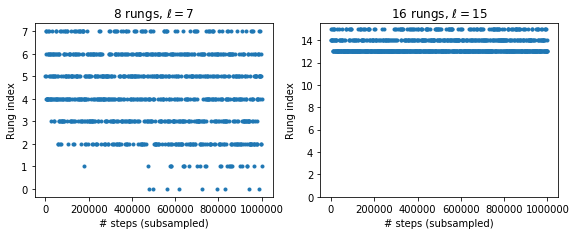

In [6]:
# plot the rung trajectories
fig, ax = plt.subplots(figsize=(8, 3))
fig.tight_layout()
plt.subplot(1,2,1)
plot_rung_traj(time, traj1)
plt.title('8 rungs, $\ell = 7$')
plt.subplot(1,2,2)
plot_rung_traj(time, traj2)
plt.gca().set_ylim([0, 15.5])
plt.title('16 rungs, $\ell = 15$');

# 8.2 History forgetting

In [7]:
# set the 'alpha' and 'epoch_count' parameters,
# as defined in the paper, Section 2.3, 
# and as discussed in the Supplementary Materials,
# Section 8
parameters1 = {'alpha' : 0.19, 
                'epoch_count' : 32, 
                'visit_control_eta' : 0.0, 
                'moves_per_estimator_update' : 1}

In [8]:
traj3 = run_setup('rungs16_windows1_alpha0.19', graph2, parameters1)

Text(0.5, 1.0, '16 rungs, $\\ell = 15$')

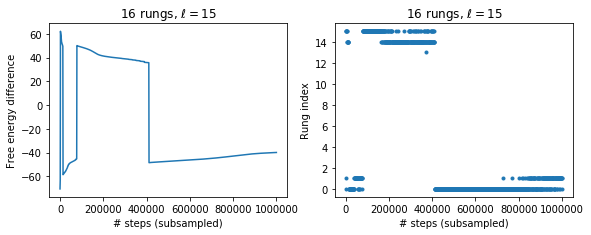

In [9]:
# plot the free energy trajectories
fig, ax = plt.subplots(figsize=(8, 3))
fig.tight_layout()
plt.subplot(1,2,1)
plot_free_energy_traj(time, traj3)
plt.title('16 rungs, $\ell = 15$')
plt.subplot(1,2,2)
plot_rung_traj(time, traj3)
plt.title('16 rungs, $\ell = 15$')

# 8.3 Windows

In [10]:
graph3 = make_graph(16, 16, False)
graph4 = make_graph(16, 8, False)
# There are 3 and 5 windows, respectively.
for g in [graph3, graph4]:
    print('There are {} windows.'.format(len(g['graph.windows'])))


There are 3 windows.
There are 5 windows.


In [11]:
traj4 = run_setup('rungs16_windows3_alpha0.19', graph3, parameters1)
traj5 = run_setup('rungs16_windows5_alpha0.19', graph4, parameters1)

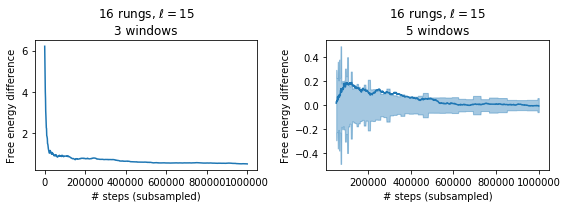

In [12]:
# plot the free energy trajectories
fig, ax = plt.subplots(figsize=(8, 3))
plt.subplot(1,2,1)
plot_free_energy_traj(time, traj4)
plt.title('16 rungs, $\ell = 15$\n3 windows')
plt.subplot(1,2,2)
plot_free_energy_traj(time, traj5, errbars=True, idx0=50)
plt.title('16 rungs, $\ell = 15$\n5 windows')
fig.tight_layout()

Text(0.5, 1.0, '16 rungs, $\\ell = 15$\n5 windows')

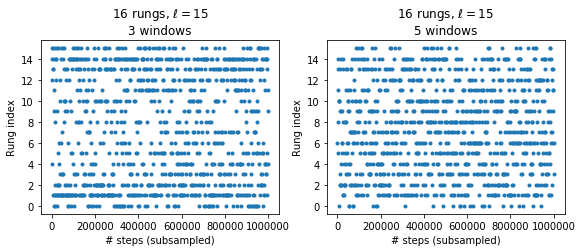

In [13]:
fig, ax = plt.subplots(figsize=(8, 3))
fig.tight_layout()
plt.subplot(1,2,1)
plot_rung_traj(time, traj4)
plt.title('16 rungs, $\ell = 15$\n3 windows')
plt.subplot(1,2,2)
plot_rung_traj(time, traj5)
plt.title('16 rungs, $\ell = 15$\n5 windows')

# 8.4 Visit control

In [14]:
graph5 = make_graph(16, 16, True)
graph6 = make_graph(64, 64, True)
parameters2 = {'alpha' : 0.19, 
                'epoch_count' : 32, 
                'visit_control_eta' : 4.0, 
                'moves_per_estimator_update' : 1}
# We run the system with 64 rungs for a smaller number of steps
# so that the simulation completes in a reasonable amount of time.
# To match Section 8, one should run with int(4e6) steps.
time1 = np.linspace(0, int(4e5)-1, int(1e2))

In [15]:
traj6 = run_setup('rungs16_windows1_alpha0.19_eta4.0', graph5, parameters2)

In [16]:
# subsampled very coarsely to avoid overloading notebook memory
traj7 = run_setup('rungs64_windows1_alpha0.19_eta4.0', graph6, parameters2, nsteps=int(4e5), write_interval=int(4e3))

Text(0.5, 1.0, '64 rungs, $\\ell = 63$\n$\\eta=4$, single window')

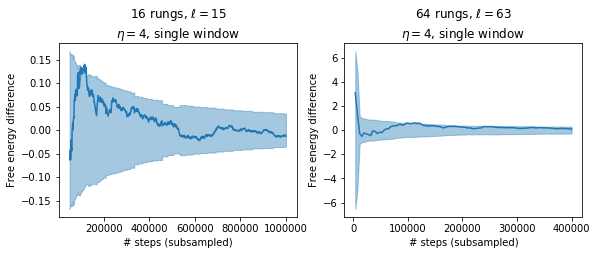

In [17]:
# plot the free energy trajectories
fig, ax = plt.subplots(figsize=(8, 3))
fig.tight_layout()
plt.subplot(1,2,1)
plot_free_energy_traj(time, traj6, errbars=True, idx0=50)
plt.title('16 rungs, $\ell = 15$\n$\eta=4$, single window')
plt.subplot(1,2,2)
plot_free_energy_traj(time1, traj7, errbars=True, idx0=1)
plt.title('64 rungs, $\ell = 63$\n$\eta=4$, single window')

# 8.5 Self-adjustment

In [18]:
parameters3 = {'alpha' : 0.19, 
                'epoch_count' : 32, 
                'visit_control_eta' : 4.0, 
                'moves_per_estimator_update' : 32}
parameters4 = {'alpha' : 0.19, 
                'epoch_count' : 32, 
                'visit_control_eta' : 4.0, 
                'moves_per_estimator_update' : 100}
time2 = np.linspace(0, int(1e5)-1, int(1e2))

In [19]:
traj8 = run_setup('rungs16_windows1_alpha0.19_eta4.0_mpeu32', graph5, parameters3, 
                  nsteps=32*int(1e5), write_interval=32*int(1e3))

In [20]:
# subsampled very coarsely to avoid overloading notebook memory
traj9 = run_setup('rungs64_windows1_alpha0.19_eta4.0_mpeu32', graph6, parameters3, 
                  nsteps=32*int(4e5), write_interval=32*int(4e3))

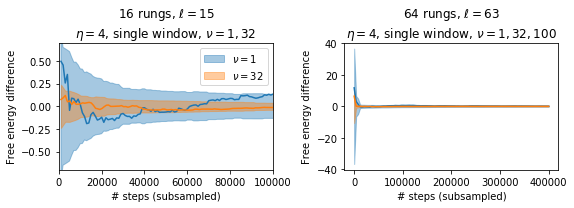

In [21]:
# plot the free energy trajectories
fig, ax = plt.subplots(figsize=(8, 3))
plt.subplot(1,2,1)
plot_free_energy_traj(time, traj6, errbars=True, idx0=1, label=r'$\nu = 1$')
plot_free_energy_traj(time2, traj8, errbars=True, idx0=1, color='C1', label=r'$\nu = 32$')
plt.axis([0, 1e5, -0.7, 0.7])
plt.title('16 rungs, $\ell = 15$\n$\eta=4$, single window, '+r'$\nu = 1, 32$')
plt.legend()
plt.subplot(1,2,2)
# moves_per_estimator_update = 100 is not shown here as it takes a significant time to run 
plot_free_energy_traj(time1, traj7, errbars=True, idx0=0, label=r'$\nu = 1$')
plot_free_energy_traj(time1, traj9, errbars=True, idx0=0, color='C1', label=r'$\nu = 32$')
plt.title('64 rungs, $\ell = 63$\n$\eta=4$, single window, '+r'$\nu = 1, 32, 100$')
fig.tight_layout()